In [31]:
# import function 
from sklearn.preprocessing import LabelEncoder
import os 
import librosa
import numpy as np
from tqdm  import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [ ]:
# label processing  

path = "./ravdess"
max_len = 92

for label in os.listdir(path):
    
    labelDir = os.path.join(path,label)
    mfcc_vector =[]

    total = len(os.listdir(labelDir))
    print(total)
    for cnt , file  in enumerate(os.listdir(labelDir)):
        filePath = os.path.join(labelDir,file)
        for wavfile in tqdm(filePath, "Saving vectors of label - '{}' {}/{}".format(label,cnt+1,total)):
            wave , sr = librosa.load(filePath)
            wave = wave[::3]
            mfcc = librosa.feature.mfcc(y=wave,sr=16000)
            
            # 將沒有到最大長度的音檔 padding 到最大
            if max_len > mfcc.shape[1]:
                pad_width = max_len - mfcc.shape[1]
                mfcc = np.pad(mfcc,pad_width=((0,0),(0,pad_width)),mode='constant')

            else:
                mfcc = mfcc[:,:max_len]
            mfcc_vector.append(mfcc)
            
    np.save(label+".npy",mfcc_vector)


In [16]:

# data split
path = "./ravdess"
def split_train_and_test(val_ratio = 0.1 , test_ratio=0.1,random_state =  51):

    
    for cnt , label in enumerate(os.listdir(path)):
        vectorFile = label+".npy"
        print(vectorFile)
        vector_data = np.load(vectorFile)
        print(vector_data.shape)
        
        if cnt == 0 :
            X = vector_data
            Y = np.zeros(X.shape[0])
        else :
            X = np.vstack((X,vector_data))
            Y = np.append(Y,np.full(vector_data.shape[0],fill_value=(cnt)))
        

    
    print("\n")
    print("total :",X.shape,Y.shape)
    X_train, X_test, y_train, y_test =train_test_split(X,Y,test_size=test_ratio,random_state=random_state)
    X_train, X_val, y_train, y_val =train_test_split(X_train,y_train,test_size=val_ratio/(1-test_ratio),random_state=random_state)
    print("train :" ,X_train.shape,y_train.shape)
    print("val   :",X_val.shape,y_val.shape)
    print("test  :" ,X_test.shape,y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [27]:
X_train, X_val, X_test, y_train, y_val, y_test = split_train_and_test()


X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1], X_val.shape[2], 1)

y_train_hot = to_categorical(y_train)
y_val_hot = to_categorical(y_val)

/kaggle/input/speech-recognize/ravdess/surprised.npy
(8448, 20, 92)
/kaggle/input/speech-recognize/ravdess/happy.npy
(15040, 20, 92)
/kaggle/input/speech-recognize/ravdess/neutral.npy
(7896, 20, 92)
/kaggle/input/speech-recognize/ravdess/fearful.npy
(15792, 20, 92)
/kaggle/input/speech-recognize/ravdess/disgust.npy
(8064, 20, 92)
/kaggle/input/speech-recognize/ravdess/sad.npy
(14288, 20, 92)
/kaggle/input/speech-recognize/ravdess/angry.npy
(15040, 20, 92)
/kaggle/input/speech-recognize/ravdess/calm.npy
(14664, 20, 92)


total : (99232, 20, 92) (99232,)
train : (79384, 20, 92) (79384,)
val   : (9924, 20, 92) (9924,)
test  : (9924, 20, 92) (9924,)


In [79]:
model = Sequential([
    Conv2D(32,kernel_size=(2,2),padding="same",activation="relu",input_shape=(20,92,1)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32,kernel_size=(2,2),padding="same",activation="relu"),
    Conv2D(32,kernel_size=(2,2),padding="same",activation="relu"),
    Flatten(),
    Dense(128,activation='relu'),
    Dropout(0.25),
    Dense(8,activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=["accuracy"])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 20, 92, 32)        160       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 10, 46, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 46, 32)        4128      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 10, 46, 32)        4128      
_________________________________________________________________
flatten_8 (Flatten)          (None, 14720)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               1884288   
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)              

In [80]:

early_stop_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor = 'val_accuracy'),
]
train=model.fit(X_train, y_train_hot, batch_size=100, epochs=100, verbose=1,callbacks=early_stop_callbacks)


Epoch 1/100
794/794 [==============================] - 6s 7ms/step - loss: 0.3905 - accuracy: 0.8905
Epoch 2/100
794/794 [==============================] - 6s 7ms/step - loss: 0.0289 - accuracy: 0.9911
Epoch 3/100
794/794 [==============================] - 6s 7ms/step - loss: 0.0235 - accuracy: 0.9920
Epoch 4/100
794/794 [==============================] - 6s 8ms/step - loss: 0.0199 - accuracy: 0.9932
Epoch 5/100
794/794 [==============================] - 6s 7ms/step - loss: 0.0157 - accuracy: 0.9945
Epoch 6/100
794/794 [==============================] - 6s 7ms/step - loss: 0.0167 - accuracy: 0.9944
Epoch 7/100
794/794 [==============================] - 6s 7ms/step - loss: 0.0130 - accuracy: 0.9956
Epoch 8/100
794/794 [==============================] - 6s 7ms/step - loss: 0.0115 - accuracy: 0.9962
Epoch 9/100
794/794 [==============================] - 6s 8ms/step - loss: 0.0152 - accuracy: 0.9952
Epoch 10/100
794/794 [==============================] - 6s 8ms/step - loss: 0.0108 - accura

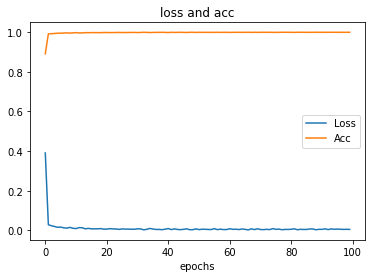

In [81]:
'''儲存訓練過程中 的 loss and acc'''
loss = train.history['loss']
acc = train.history['accuracy']
    
'''圖形印出loss and acc '''
plt.title('loss and acc')
plt.plot(loss)
plt.plot(acc)
plt.legend(['Loss', 'Acc'])
plt.xlabel('epochs')
plt.show()

# 模型存檔
model.save('ASR.h5')  # creates a HDF5 file 'model.h5'

In [82]:
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder

In [84]:

model = load_model("ASR.h5")
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
res = model.predict(X_test)
labelencoder = LabelEncoder()
y_test = labelencoder.fit_transform(y_test)
correct = 0
for i in range(len(res)) : 
    correct += (np.argmax(res[i])==y_test[i])
print(f"acc :{correct/len(res) *100}%")

acc :100.0%
